 ### **Question D | Bouchaud Transitory Impact Model**

> With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price
impact model. Comment the obtained values. Is this model well specified?

In [10]:
# Open TD4 data
import pandas as pd
df = pd.read_excel("Dataset TD4.xlsx")
df

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060
...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070
997,0.981875,0.1010,NaN,-1,101.120
998,0.986784,0.1007,NaN,-1,100.998
999,0.991232,0.1153,3.0,-1,100.958


In [11]:
# Rename the columns for simplicity
df.rename(columns={'transaction date (1=1day=24 hours)': 'date', 'bid-ask spread': 'spread', 'volume of the transaction (if known)': 'volume', 'Sign of the transaction': 'sign', 'Price (before transaction)': 'price'}, inplace=True)
df.head()

,date,spread,volume,sign,price
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060


Bouchaud's transitory impact model is specified as:
$$p_t = p_{-\infty} + \sum^{t-1}_{s=-\infty}G(t-s)\epsilon_s S_s V^r_s$$

Where:
- $S$ is the bid-ask spread;
- $\epsilon$ is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell (price = bid) on the market;
- $V$ is the volume of the transaction, with $r$ close to zero to have a concave function of the volume;
- $G$ is a function worth 0 on $\mathbb{R}^-$, which can be interpreted as the impact of a single order.

There are many NaNs in the volume column, and we don't have a reason to believe they are all quote updates, so we will fill the missing values with the median of the volume column.


In [12]:
# We replace missing values by the median to avoid losing most the data
df['volume'] = df['volume'].fillna(df['volume'].median())
df.head()

,date,spread,volume,sign,price
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,77.0,1,99.984
2,0.001496,0.1015,77.0,-1,100.029
3,0.003336,0.0920,77.0,1,99.979
4,0.003952,0.1106,77.0,1,100.060


Let's plot the price evolution, this will allow us to get a clearer view on the data

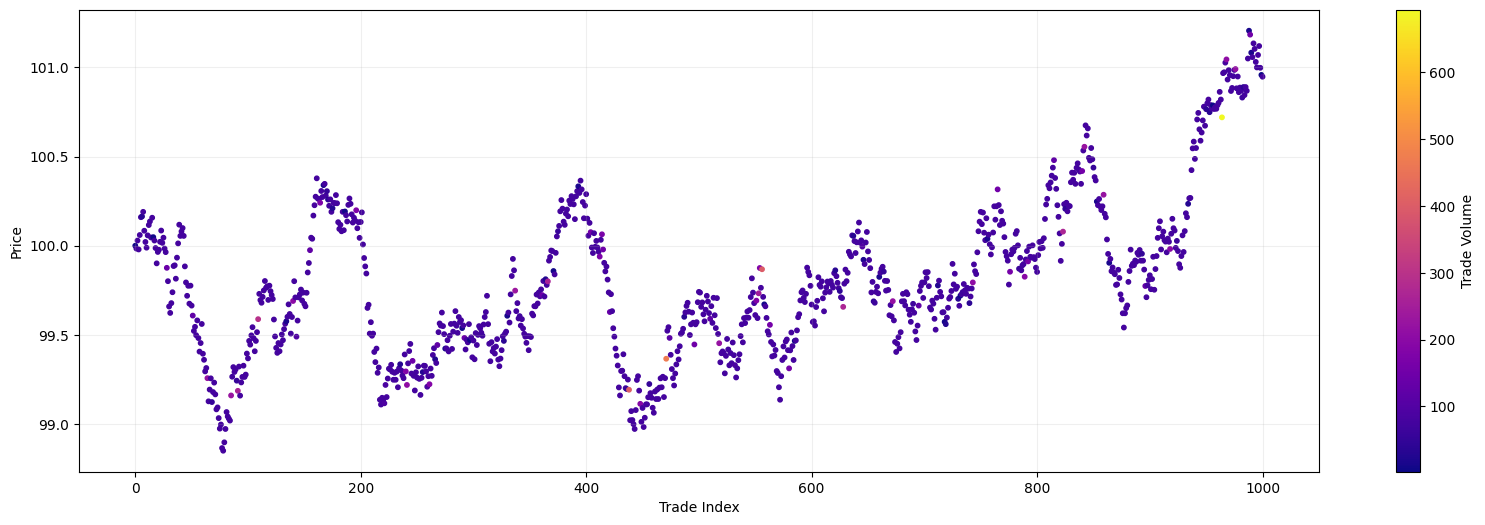

In [13]:
import matplotlib.pyplot as plt
# Setup the plot
fig, ax = plt.subplots(figsize=(20, 6))
# We plot the price evolution with color intensity for the volume
sc = ax.scatter(df.index, df['price'], c=df['volume'], cmap='plasma', s=10)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Trade Volume')
ax.set_xlabel('Trade Index')
ax.set_ylabel('Price')
ax.grid(True, alpha=0.2)
plt.show()

To estimate the parameters of the Bouchaud model, we want to have a series of price returns instead of pure value.

Indeed, we can transform the equation:

$$p_{t+1} - p_t = \sum_{l=0}^{L} \left[ G(l+1) - G(l) \right] \cdot (\epsilon_{t-l} S_{t-l} V_{t-l}^r)$$

For which we want to estimate $\Delta G$ and $r$.

Since $r$ is non-linear, we cannot estimate it with a linear regression, so we will solve for the parameters in two steps:
1. Do a grid search for $r$ and maximize the regression $R^2$ over multiple potential $r$ values.
2. To estimate the propagator function $G$ using the optimal $r$, we will estimate the coefficients $\beta_k$ of the differenced price equation and reconstruct $G(\tau) = \sum \beta_k$ with $\tau$ a fixed number of steps.

In [14]:
# We reformat the dataset to have a clearer view of what happens by aligning the impacted price to the trade that impacts it
df['next_price'] = df['price'].shift(-1)
# We compute the returns because we need them in the model equation
df['price_change'] = df['next_price'] - df['price']
df = df.dropna(subset=['price_change'])
df.head()

,date,spread,volume,sign,price,next_price,price_change
0,0.000202,0.1100,8.0,-1,100.000,99.984,-0.016
1,0.001070,0.1030,77.0,1,99.984,100.029,0.045
2,0.001496,0.1015,77.0,-1,100.029,99.979,-0.050
3,0.003336,0.0920,77.0,1,99.979,100.060,0.081
4,0.003952,0.1106,77.0,1,100.060,100.160,0.100


Market impact is concave with respect to volume, which means for example that a trade 10x larger moves the price less than 10x as much. This is why we have the exponent $r < 1$. But because $r$ is an exponent, we cannot find it using a linear regression directly as it makes the equation non-linear.

To solve that problem, we will do a grid search with different values of $r \in [0.1, 1]$ to estimate its true value.

In [15]:
import numpy as np
# We hope scikit can be used in the context of a regression for the project
from sklearn.linear_model import LinearRegression
# We define a number of lags of 100, we look 100 steps back in the data
L = 100
# test 30 r values from 0.1 to 1.0, it's the grid that will be searched
r_grid = np.linspace(0.1, 1.0, 30)

scores = []
models = {}
# We define the impact term of the Bouchaud model= epsilon * spread * volume^r
def impact(df, r):
    return df['sign'] * df['spread'] * (df['volume'] ** r)

The regression problem can be written this way: 

$$\text{R}_t = \beta_0 \cdot I_t + \beta_1 \times I_{t-1} + \beta_2 \times I_{t-2} + \dots + \beta_{99} \times I_{t-99}$$

In [16]:
# Grid search
for r in r_grid:
    # First calculate impact term for the current r
    df2 = df.copy()
    df2['impact'] = impact(df2, r)
    # we then add the lagged values
    # We want to predict price change at t using the past impacts
    features = []
    # We create lagged columns for each step that we look back to
    for i in range(L):
        # Label columns lag_i
        col_name = f'lag_{i}'
        # slide the impact column in the dataframe by i steps
        df2[col_name] = df2['impact'].shift(i)
        # We then add to features
        features.append(col_name)
    #remove missing values created by shifting data
    reg_df = df2.dropna(subset=features)
    # We structure the regression model specified above
    X = reg_df[features]
    y = reg_df['price_change']
    # run the linear regression
    reg = LinearRegression() 
    reg.fit(X, y)
    # get the result
    score = reg.score(X, y) 
    scores.append(score)
    models[r] = reg

C:\Users\Adrien\AppData\Local\Temp\ipykernel_21276\3178462625.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col_name] = df2['impact'].shift(i)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_21276\3178462625.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col_name] = df2['impact'].shift(i)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_21276\3178462625.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

Chosen r: 0.5655
R2: 0.7899


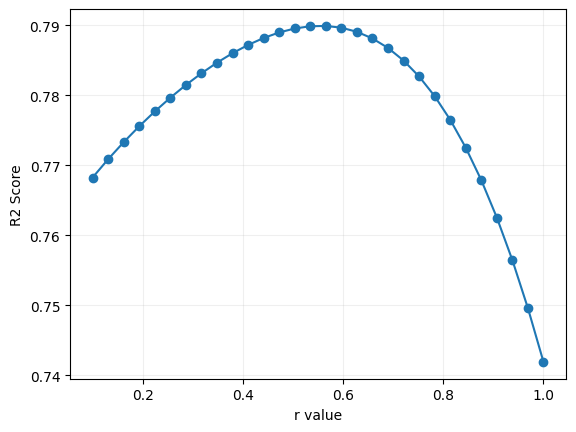

In [17]:
# Finally, we keep the most accurate value found of r
fin_idx = np.argmax(scores)
fin_r = r_grid[fin_idx]
fin_r2 = scores[fin_idx]
fin_model = models[fin_r]
# show results
print(f"Chosen r: {fin_r:.4f}")
print(f"R2: {fin_r2:.4f}")
# We make a plot for the report
plt.figure()
plt.plot(r_grid, scores, 'o-')
plt.xlabel("r value")
plt.ylabel("R2 Score")
plt.grid(True, alpha=0.2)
plt.show()

The grid search allowed us to find an appropriate value for the $r$ parameter. $r=0.5655$ is here close to $0.5$, which means the exponent for $V_s$ is close to a square root.

The next step is the reconstruction of the function $G$. The regression coefficients $\beta_l$ correspond to the increments of the propagator function:
$$\beta_l \approx G(l+1) - G(l)$$
To recover the real shape of the propagator function $G(\tau)$, we can compute the cumulative sum of these coefficients:
$$G(\tau) = \sum_{k=0}^{\tau-1} \beta_k$$

And then we fit the power-law decay to the empirical propagator to generalize an estimation:
$$G(\tau) \approx \frac{A}{\tau^\beta}$$

In [18]:
from scipy.optimize import curve_fit
# Recalculate the specific impact term with the best r
df['best_impact'] = df['sign'] *df['spread'] * (df['volume'] ** fin_r)
# Create the lag data matrix again for the optimal r
X = pd.DataFrame()
L = 100
# We create the lagged columns for each step that we look back to
for i in range(L):
    X[f'lag_{i}'] = df['best_impact'].shift(i)
# Align Data
valid_idx = X.dropna().index
y = df.loc[valid_idx, 'price_change']
X = X.loc[valid_idx]
# run the linear regression
reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)
# We retrieve the coefficients from the model
coef = reg.coef_
# compute the sum to recover the propagator shape G
G = np.cumsum(coef)
# Define the range we will use for plot
lags = np.arange(1, L + 1)
# Define the power law function for the decay
def power(t, lam, gamma):
    return lam * np.power(t, -gamma)
# we fit the power law to find amplitude lambda and decay speed gamma
popt, pcov = curve_fit(power, lags, G, p0=[G[0], 0.5])
lambda_est, gamma_est = popt
# Output the estimated parameters
print(f"Immediate impact G(1): {G[0]:.6f}")
print(f"Decay amplitude lambda: {lambda_est:.6f}")
print(f"Decay exponent gamma: {gamma_est:.4f}")

C:\Users\Adrien\AppData\Local\Temp\ipykernel_21276\4079241082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['best_impact'] = df['sign'] *df['spread'] * (df['volume'] ** fin_r)


Immediate impact G(1): 0.052172
Decay amplitude lambda: 0.056020
Decay exponent gamma: 0.0813


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Adrien\AppData\Local\Temp\ipykernel_21276\1982817651.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(smooth_lags, power(smooth_lags, lambda_est, gamma_est),'r--', label=f'Fit: $\lambda \\cdot \\tau^{{-{gamma_est:.2f}}}$')


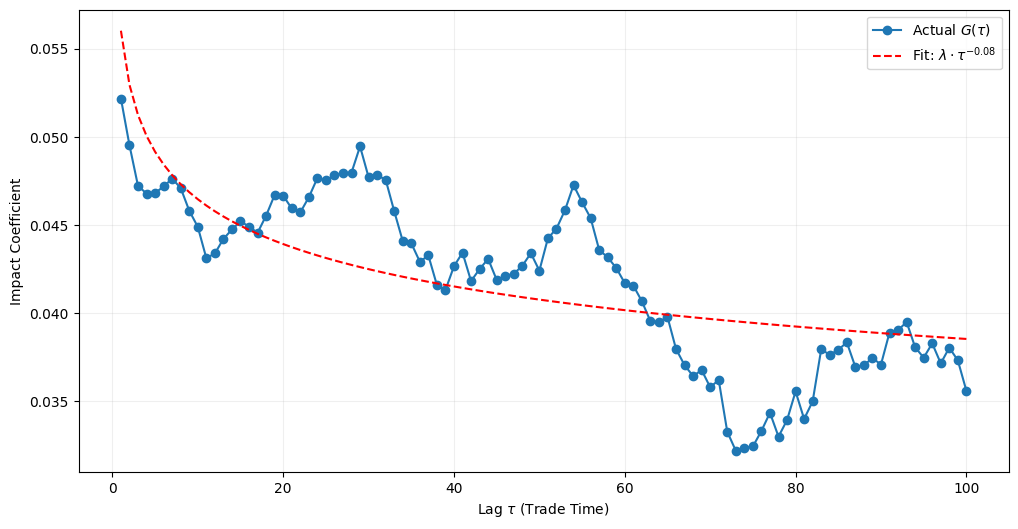

In [19]:
# Plotting for the report
plt.figure(figsize=(12, 6))
# Plot actual G
plt.plot(lags, G, 'o-', label='Actual $G(\\tau)$')
# Plot the fitted curve
smooth_lags = np.linspace(1, L, 100)
plt.plot(smooth_lags, power(smooth_lags, lambda_est, gamma_est),'r--', label=f'Fit: $\lambda \\cdot \\tau^{{-{gamma_est:.2f}}}$')
plt.xlabel("Lag $\\tau$ (Trade Time)")
plt.ylabel("Impact Coefficient")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Let's evaluate the parameters estimates:

1) Volume Exponent ($r \approx 0.57$): The estimated value is close to 0.5, which corresponds to the theoretical nature of market impact defined by Bouchaud. Indeed, it confirms that price impact is a concave function of volume, which means that if a trader doubles their volume, they don't move the price by $2\times$, but around $\sqrt{2}\times$. 

2) Decay Exponent ($\gamma = 0.0813$): The decay parameter of the model is positive but small. This could mean the process has a long memory. While the impact is technically transitory (tends towards zero), its decay is very slow, so even after 100 trades we see the influence of the original price move. What we understand from what the Bouchaud model indicates is that here the asset exhibits a sticky or trending price, at least on the given time frame.

Finally, to answer the question if the model is well specified:

1) We see that the reconstructed propagator function $G(\tau)$ is positive and monotonic, it respects the requirements for a valid kernel function.

2) Also, the amplitude of the power law fitted $\lambda$ and $G(1)$ are around the same value, which indicates the power function we estimated $G(\tau) \sim \tau^{-\gamma}$ is an okay fit for the decay shape, though we see on the curve the actual fluctuations of the $G$ function are quite irregular.